# HarvestStat Data Profiling - Kenya

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32736' # Kenya
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/KE_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s = %s.dissolve("FNID").reset_index()' % (name, name))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Kenya',
    'product':['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1982	 | KE1982A1 | 8	| KE1982A2	| 41	| nan	| 0	|
| 1989	 | KE1989A1 | 8	| KE1989A2	| 47	| nan	| 0	|
| 2007	 | KE2007A1 | 8	| KE2007A2	| 70	| nan	| 0	|
| 2009	 | KE2009A1 | 8	| KE2009A2	| 47	| nan	| 0	|
| 2013	 | KE2013A1 | 47	| KE2013A2	| 290	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Save data
df_raw_out = '../data/crop_raw_data/adm_crop_data_raw_KE.csv'
df.to_csv(df_raw_out); print(f'{df_raw_out} is saved.')

../data/crop_raw_data/adm_crop_data_raw_KE.csv is saved.


In [4]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([KE_Admin2_1982, KE_Admin2_1989, KE_Admin1_2013], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 16,588
Removed 356 "Missing Value" points
5,430/5,500 "Area Planted" points are retained.
5,438/5,500 "Quantity Produced" points are retained.
5,364/5,500 "Yield" points are retained.
0/88 "Area Harvested" points are retained.
Current data points: 16,232

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1982 - 2019
22 grain types are found: Arrowroot, Banana (unspecified), Barley (Unspecified), Beans (mixed), Cassava, Cocoyam, move to 1594aa, Coffee (unspecified), Cotton (Unspecified), Cowpeas (Mixed), Gram (Green), Groundnuts (In Shell), Maize Grain (White), Millet, Pigeon Peas, Potato (Irish), Rice (Paddy), Sorghum, Soybean (unspecified), Sweet Potatoes, Tea Plant, Wheat Grain, Yams
3 seasons are found: Annual harvest (10-01), Long rains harvest (07-01), Short rains harvest (02-01)
1 crop production system are found: none
Data sources include:
[1] M

- Kenya crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-kenya.png?itok=0Wob_hCK" width=900>

- FDW data consists of `KE1982A1`, `KE1982A2`, `KE1989A1`, `KE1989A2`, `KE2013A1`.

| Year | Admin-1 | # units  | Admin-2  | # units |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1982 | **`KE1982A1`**| 8  | **`KE1982A2`** | 41|
| 1989 | **`KE1989A1`**| 8  | **`KE1989A2`** | 47|
| 2009 | KE2009A1| 8        | KE2009A2 | 47      |
| 2013 | **`KE2013A1`**| 47 | KE2013A2 | 290     |

- Comparison between admin boundaries.

<img src="../figures/KE_admin_shapes.png" width=900>

- In 1989, 6 districts are divided and added.

| 1982-1989 (original) |1989-2013 (changed)|1989-2013 (added)|
| :---:| :---:|:---:|
|Meru (KE1982A25020)    | Meru (KE1989A25017)    | Tharaka Nithi (KE1989A25018)|
|Machakos (KE1982A25019)| Machakos(KE1989A25004) | Makueni       (KE1989A25005)|
|Kericho  (KE1982A25424)| Kericho  (KE1989A25422)| Bomet         (KE1989A25420)|
|Kissi    (KE1982A25319)| Kissi    (KE1989A25314)| Nyamira       (KE1989A25308)|
|Homa Bay (KE1982A25318)| Homa Bay (KE1989A25313)| Migori        (KE1989A25316)|
|Kakamega (KE1982A25512)| Kakamega (KE1989A25511)| Vihiga        (KE1989A25508)|

- In 2013, Admin-2 became Admin-1 (no name changes).
- **`KE2013A1`** is used to represent all admin-level 1 crop data.
- Kenya has three crop seasons: `Annual harvest`, `Long rains harvest`, `Short rains harvest`.
- Kenya has a single crop production system: `None`.

In [5]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = KE_Admin1_2013.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
df['season_name'] = df['season_name'].replace({'Annual harvest':'Annual', 'Long rains harvest':'Long', 'Short rains harvest':'Short'})
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [6]:
# Link admin boundaries ------------------------- #
link_1982, over_1982 = FDW_PD_CreateAdminLink(KE_Admin2_1982, KE_Admin1_2013, 'ADMIN2', 'ADMIN1', prod, epsg)
assert all(np.unique([v['method'] for k,v in link_1982.items()]) == 'PBR')
link_1989, over_1989 = FDW_PD_CreateAdminLink(KE_Admin2_1989, KE_Admin1_2013, 'ADMIN2', 'ADMIN1', prod, epsg)
assert all(np.unique([v['method'] for k,v in link_1989.items()]) == 'PBR')
# Crop specific ratios
link_ratio_1982 = FDW_PD_RatioAdminLink(link_1982, prod, over_1982, mdx_pss)
link_ratio_1989 = FDW_PD_RatioAdminLink(link_1989, prod, over_1989, mdx_pss)
# Merge link_ratio
assert link_ratio_1982.keys() == link_ratio_1989.keys()
link_merged = [link_ratio_1982, link_ratio_1989]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

In [7]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# - Remove "Short" season yield over 4 mt/ha
rdx = crop_new.loc[:,pd.IndexSlice[:,:,'Maize Grain (White)','Short']] > 4
crop_new[rdx] = np.nan
# prod_new[rdx] = np.nan
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

All [country, season_name] are in the external season calendar.


# Postprocessing outlier removal

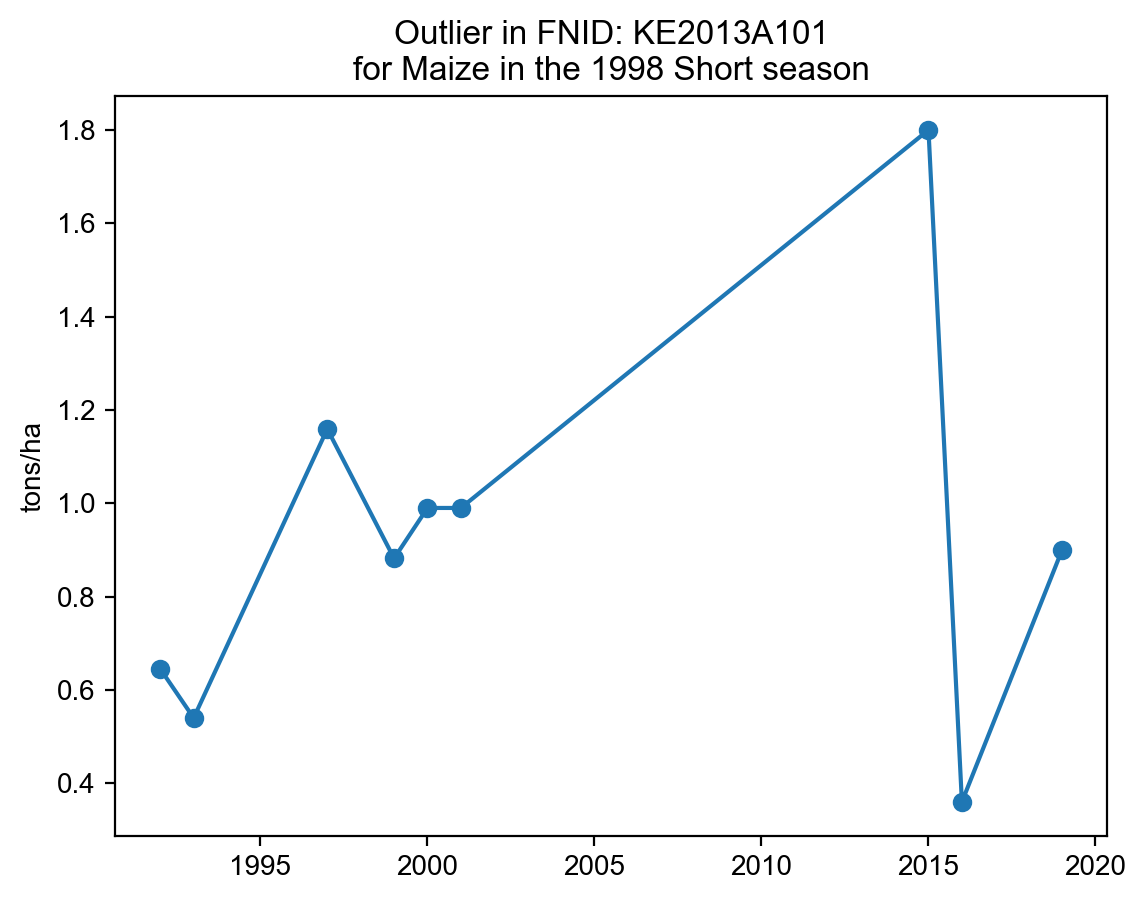

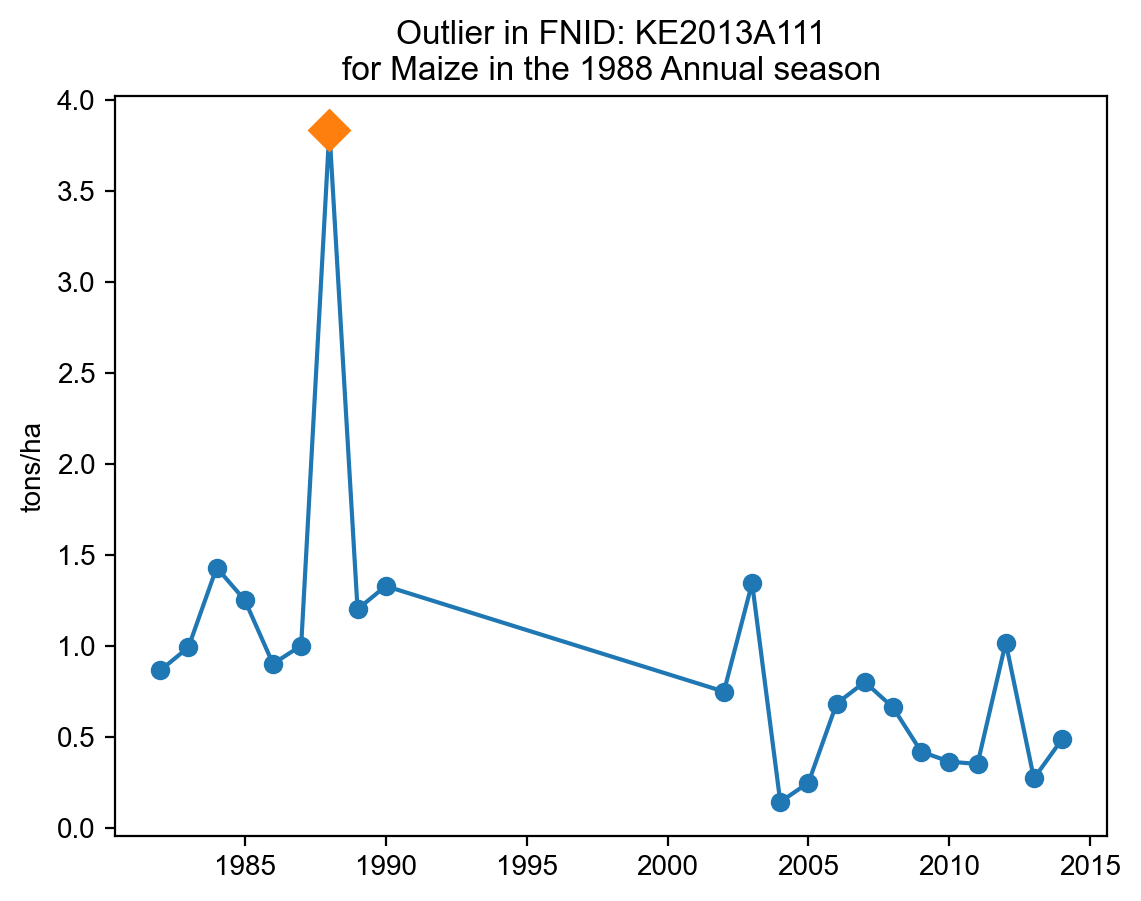

In [8]:
from matplotlib import pyplot as plt

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0


outliers = [
    ['KE2013A101','Maize','Short',1998],
    ['KE2013A111','Maize','Annual',1988]
]
stack=stack.sort_values(by='harvest_year')

#first plot, then flag the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title('Outlier in FNID: '+iou[0]+'\nfor '+iou[1]+' in the '+str(iou[3])+' '+iou[2]+' season')
    plt.ylabel('tons/ha')
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1  

In [9]:
# Save data
fn_out = '../data/crop/adm_crop_production_KE.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_KE_ratio.npz', link_ratio)

../data/crop/adm_crop_production_KE.csv is saved.
../data/crop/adm_crop_production_KE_ratio.npz is saved.


# Visualization of production data

/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


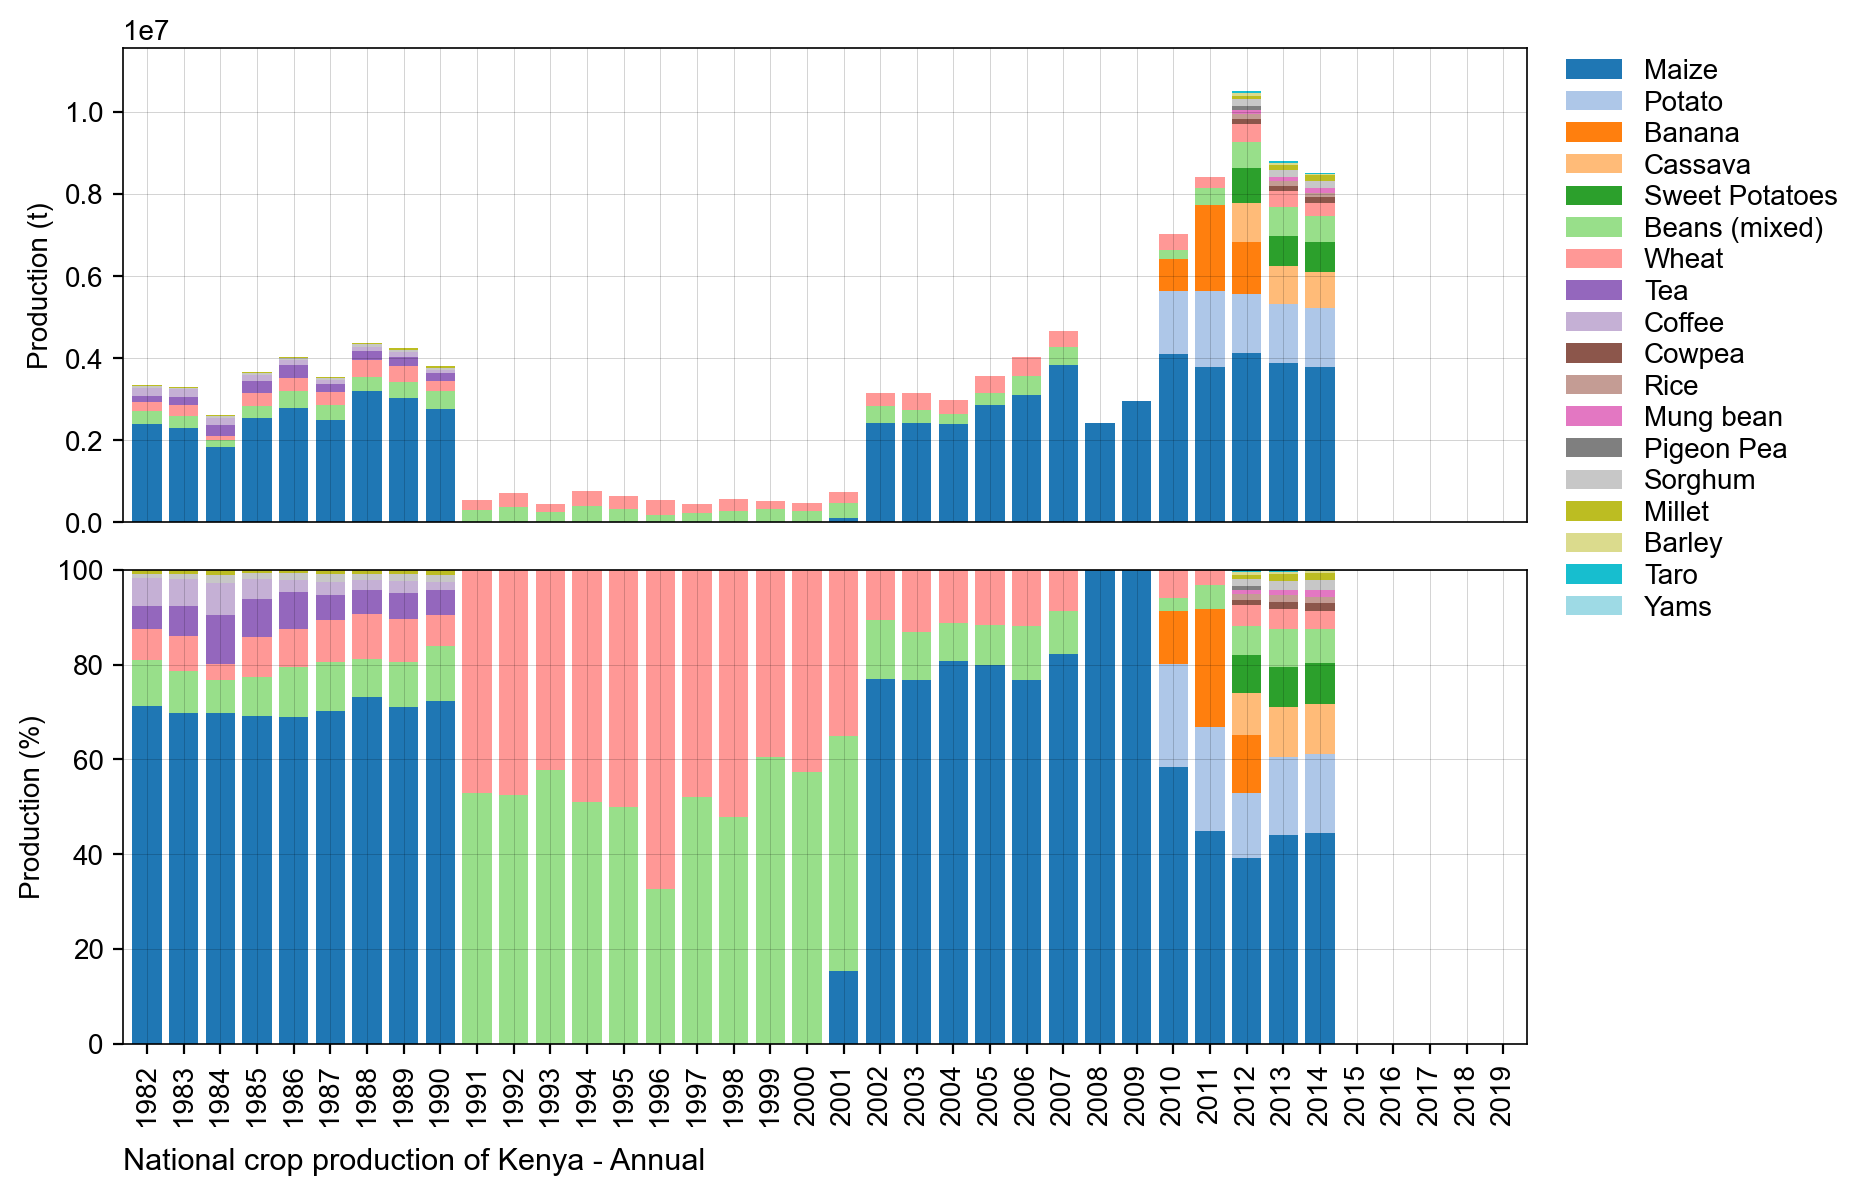

../figures/KE_bar_natgrainprod_Annual.png is saved.


/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


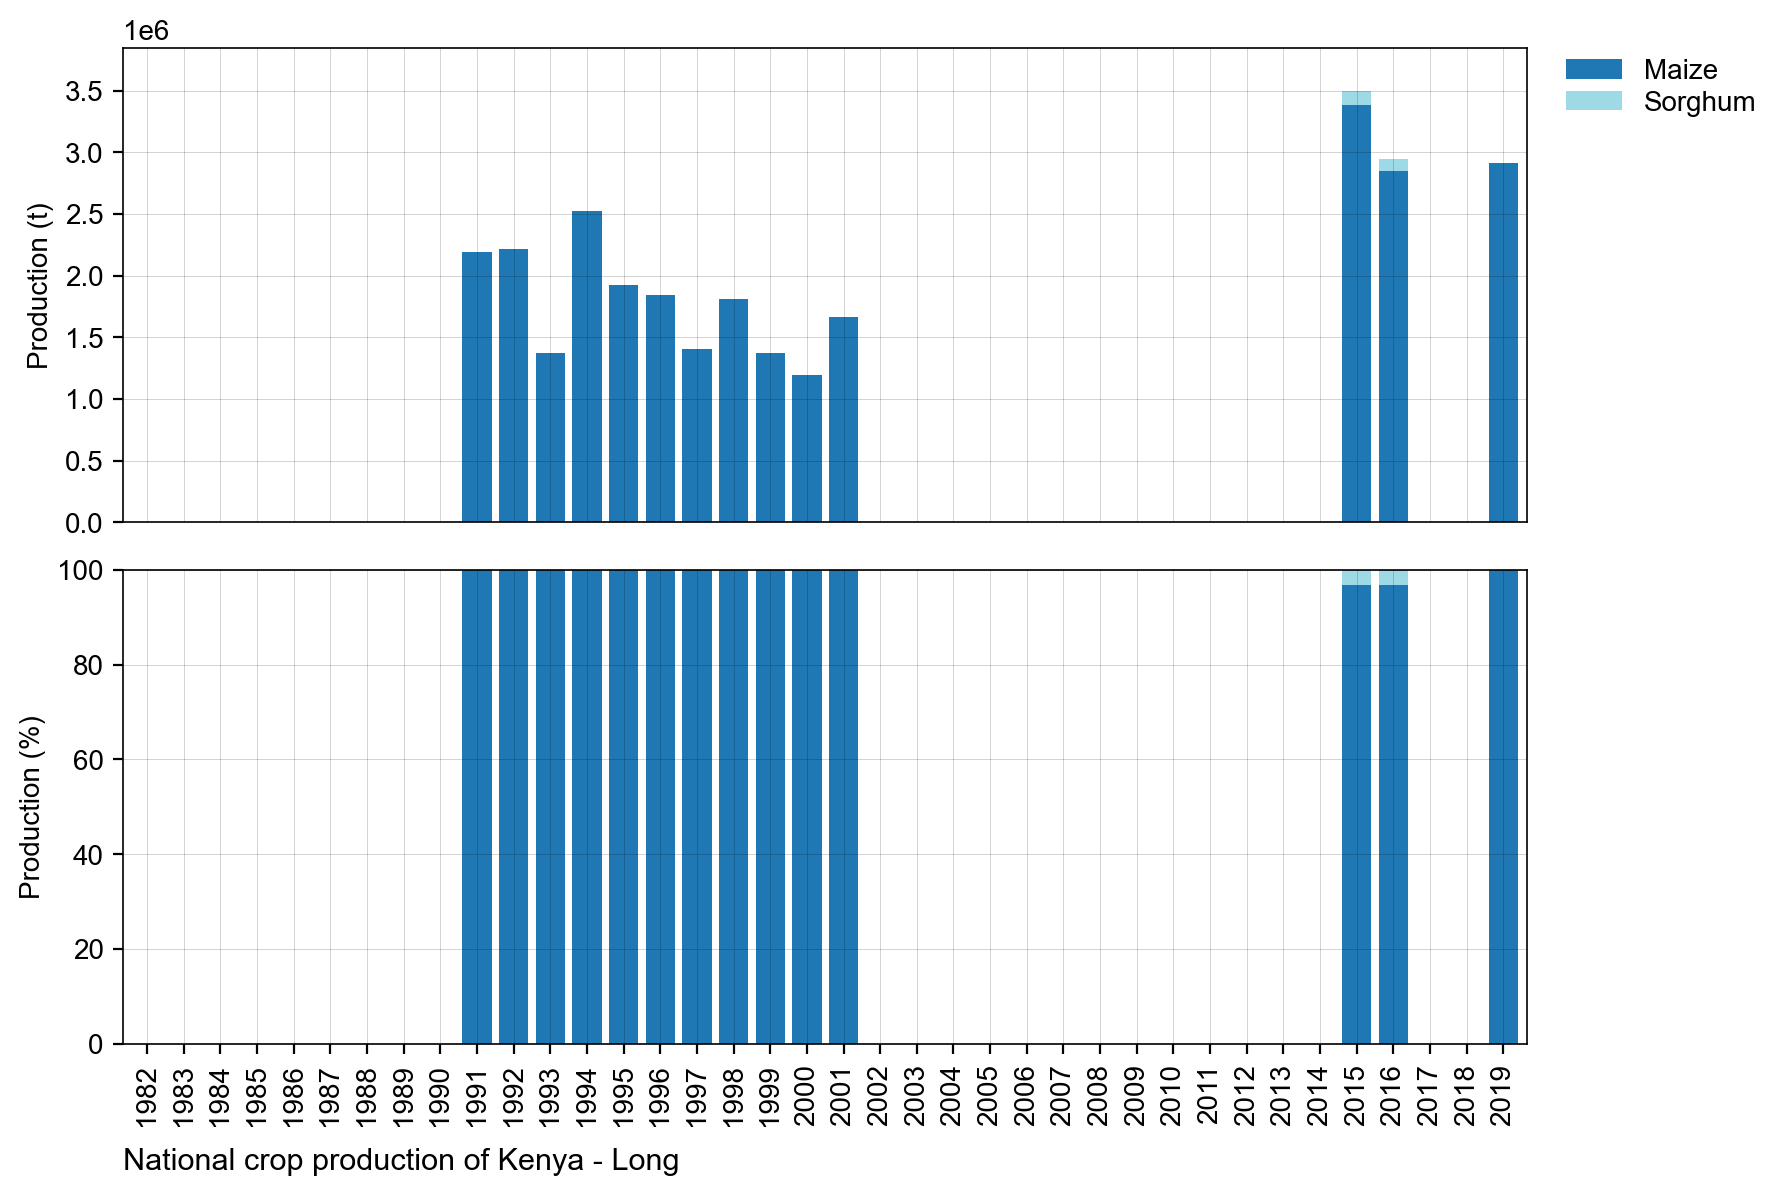

../figures/KE_bar_natgrainprod_Long.png is saved.


/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


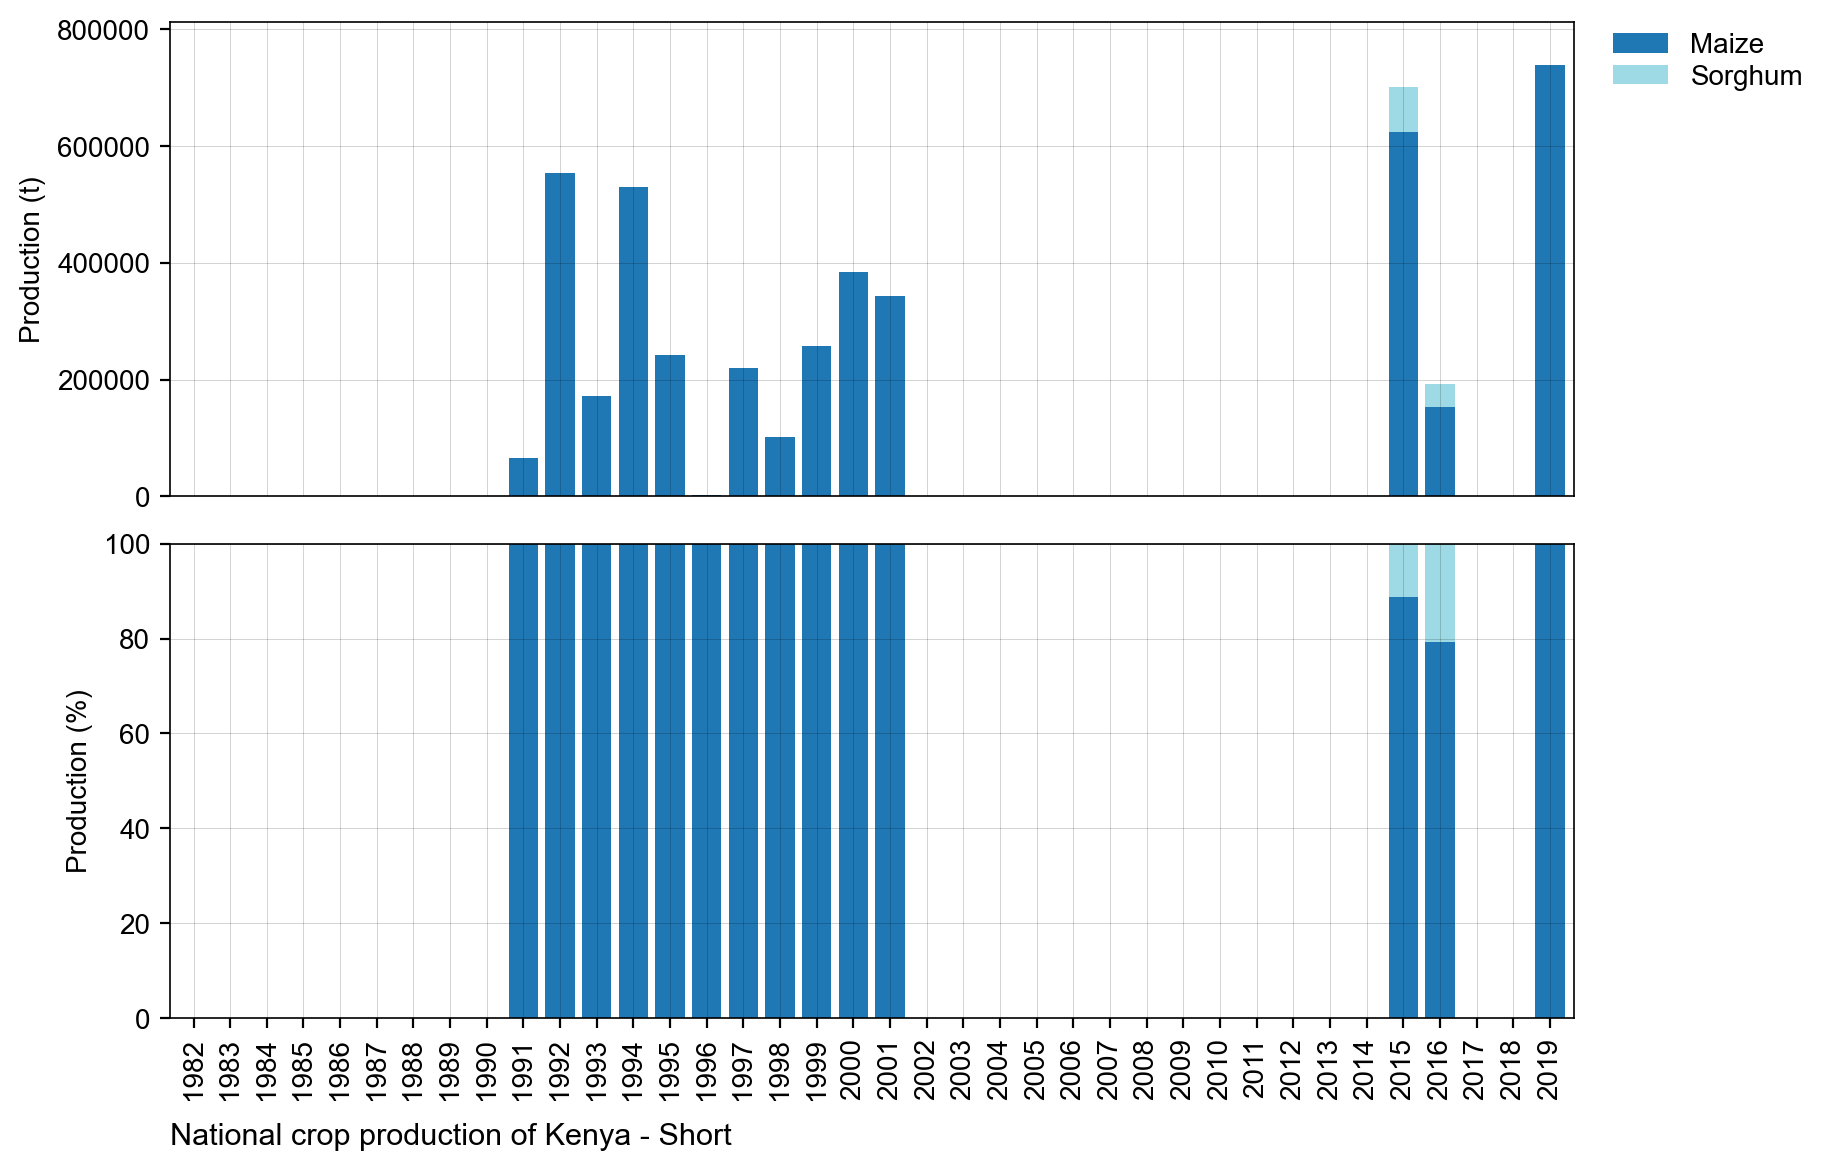

../figures/KE_bar_natgrainprod_Short.png is saved.


In [10]:
# Bar chart of national crop production
country_iso, country_name = 'KE', 'Kenya'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Annual','Long','Short']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

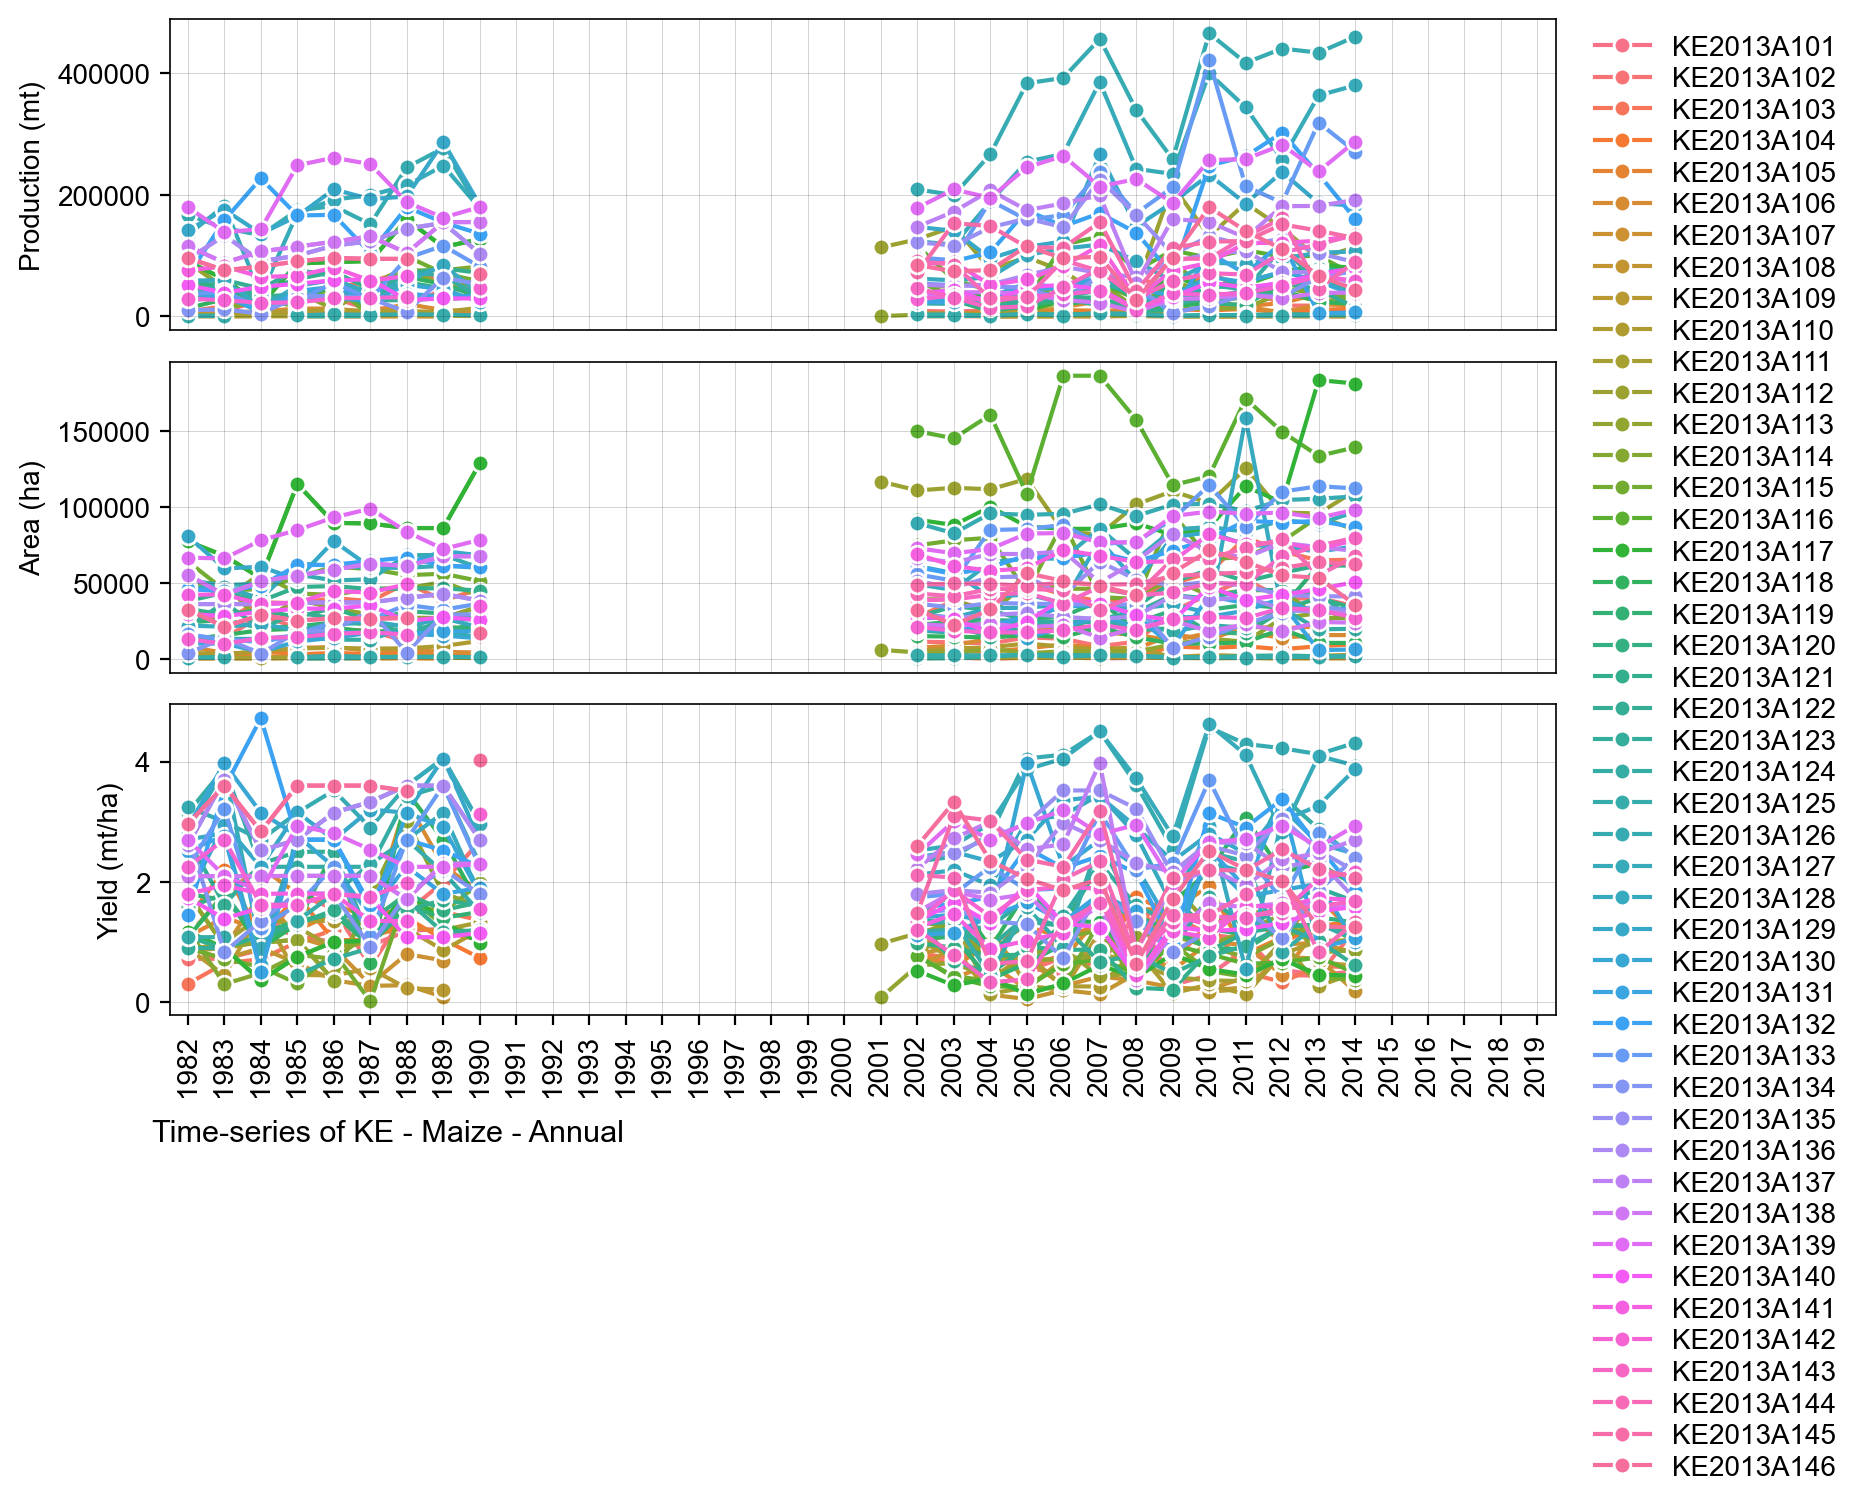

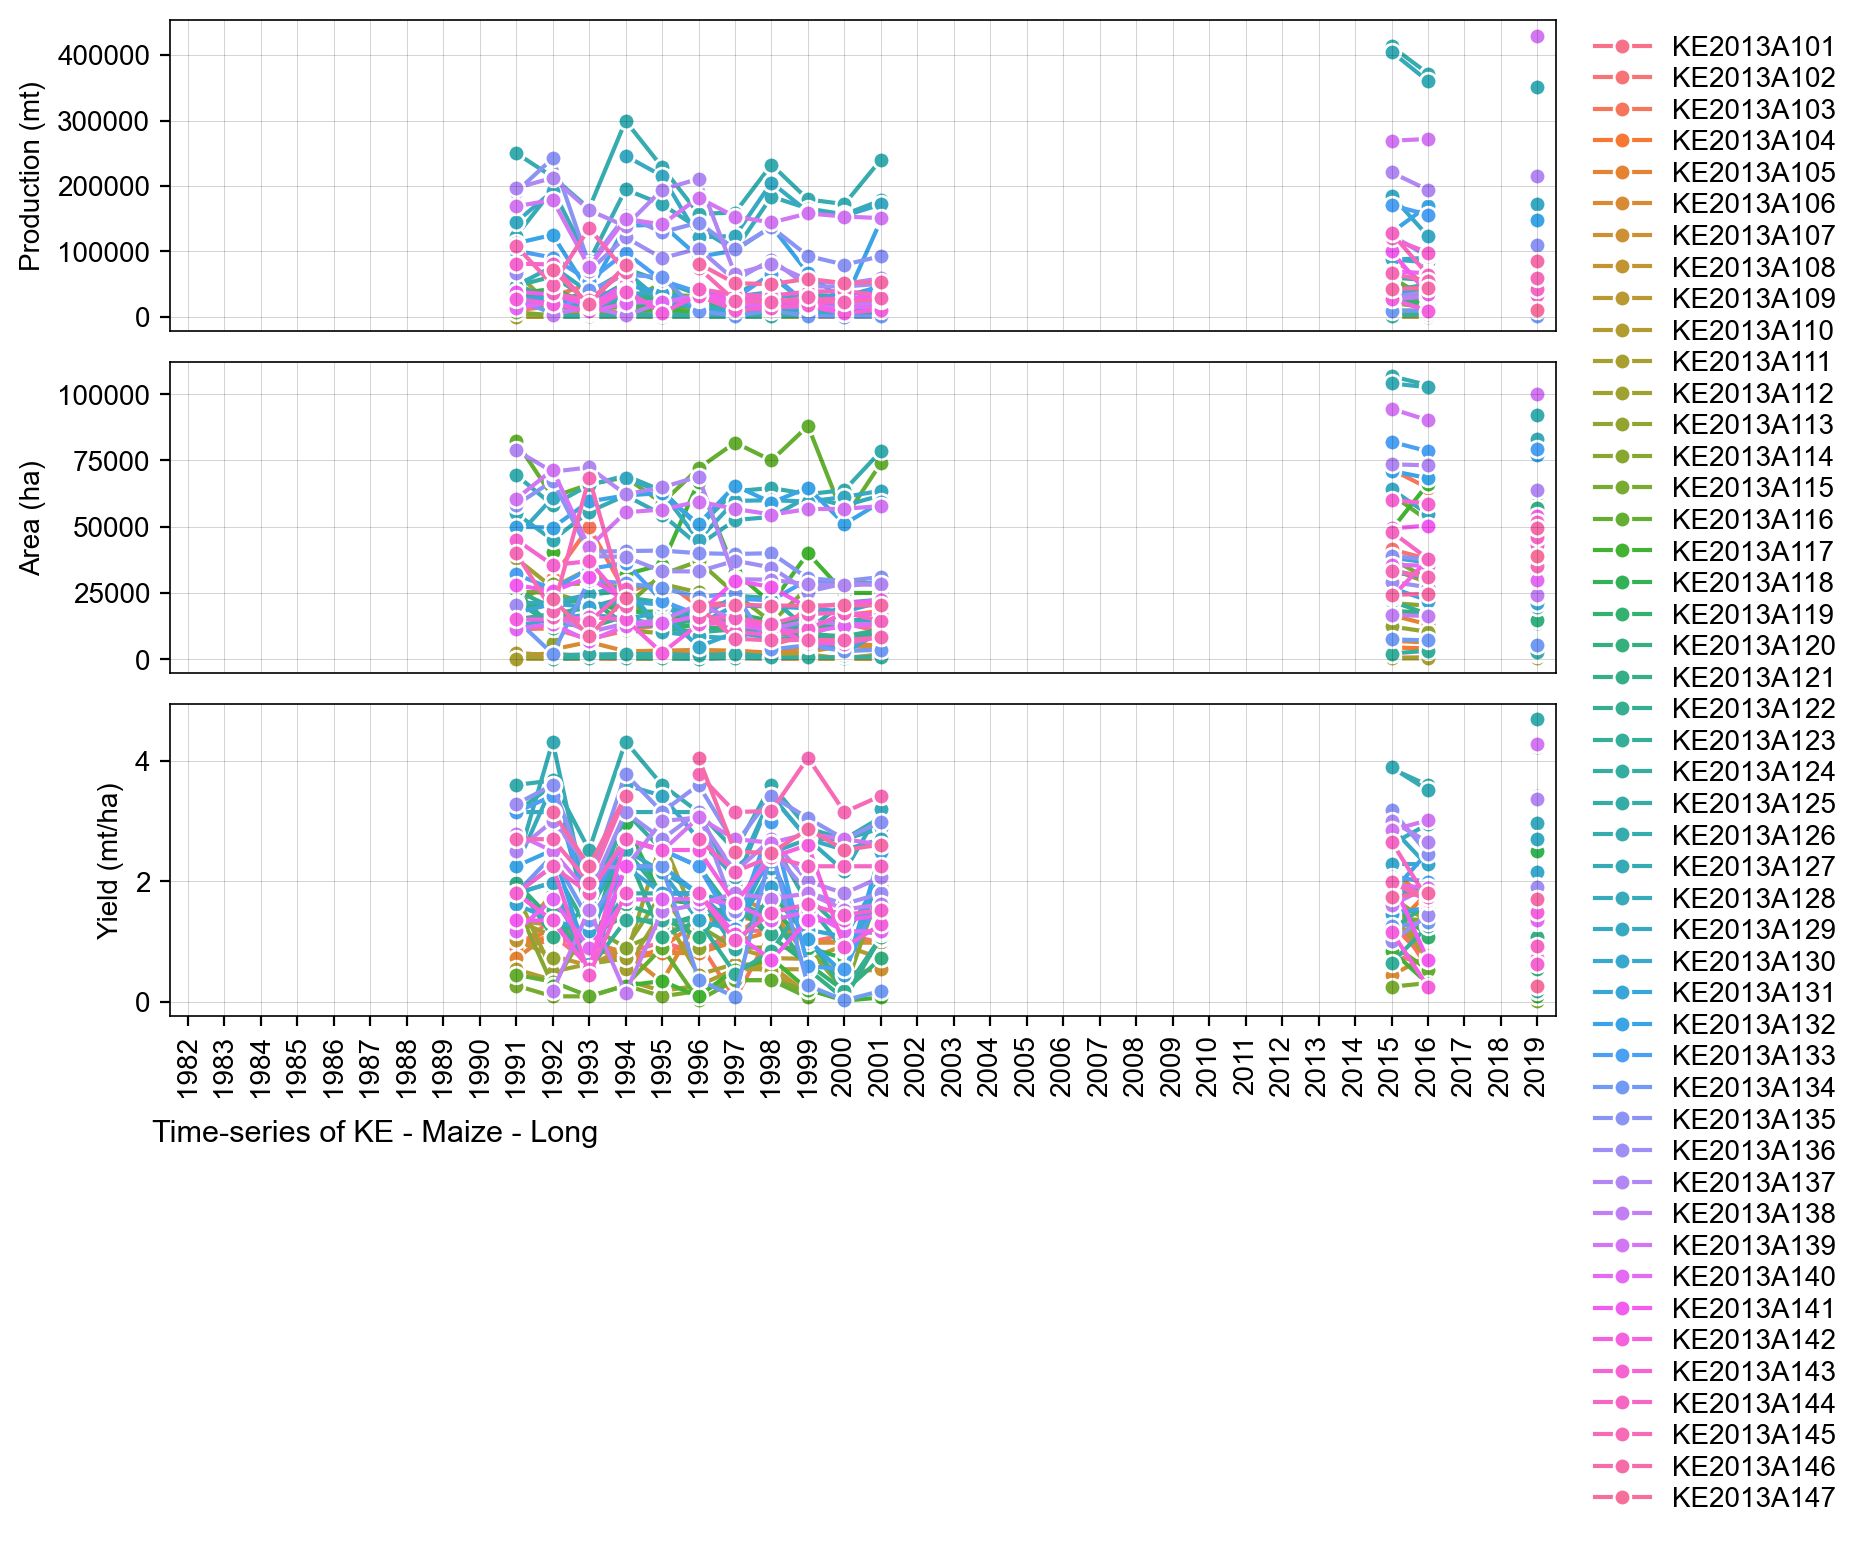

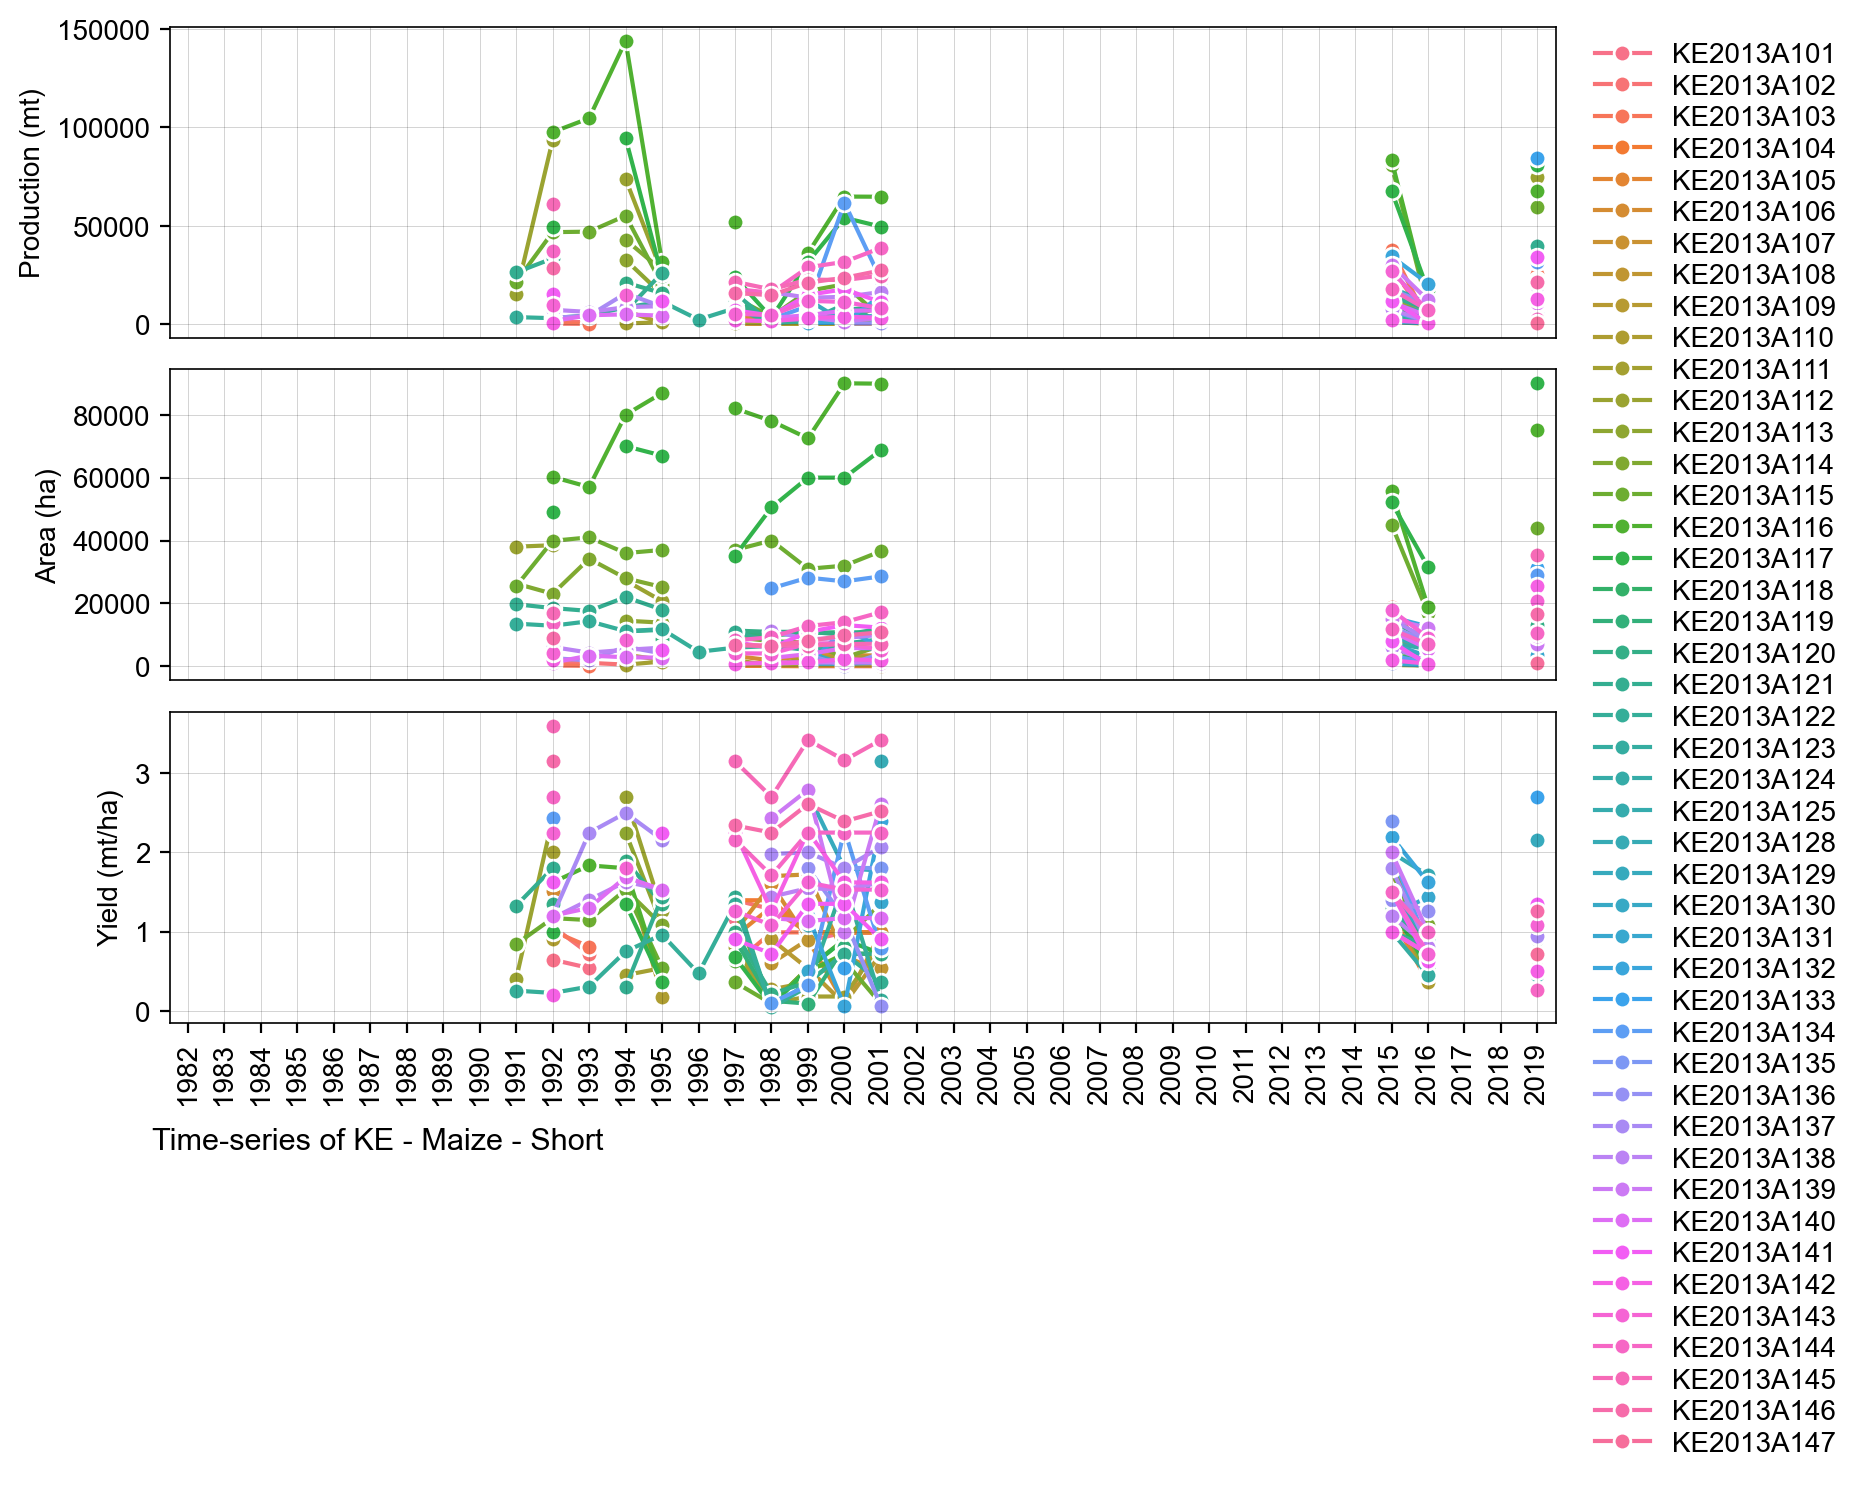

In [11]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'KE', 'Kenya'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize','Annual'],
    ['Maize','Long'],
    ['Maize','Short']
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)